# AQI Forecasting with LSTM
Goal: forecast monthly AQI for Delhi using a stacked LSTM model.

**Workflow**
- Setup and load the `city_day.csv` dataset
- Clean, resample monthly, visualize trend and seasonality
- Split train/test, scale values, and build sequences
- Define and train an LSTM forecaster
- Evaluate on holdout data and project the next 12 months

In [49]:
#Importing the required libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML,display

warnings.filterwarnings("ignore")

import tensorflow as tf
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


## 1. Load and scope the dataset
- Read the India city-level AQI data
- Keep City/Date/AQI columns and focus on Delhi

In [50]:
df= pd.read_csv("./datasets/city_day.csv",parse_dates=True)

In [51]:
#Keeping only the columns needed
df=df[['City','Date','AQI']]

In [52]:
delhi = df[df['City'] == 'Delhi']
delhi.drop(['City'],axis=1,inplace = True)
delhi['Date'] = pd.to_datetime(delhi['Date'])
delhi.set_index('Date', inplace = True)

In [53]:
delhi

,AQI
Date,
2015-01-01,472.0
2015-01-02,454.0
2015-01-03,143.0
2015-01-04,319.0
2015-01-05,325.0
...,...
2020-06-27,112.0
2020-06-28,196.0
2020-06-29,233.0


## 2. Clean and resample
- Backfill any missing AQI values
- Convert to monthly averages for smoother trends

In [54]:
#Fill NULL DATA
delhi['AQI'] = delhi['AQI'].bfill()

In [55]:
#Taking monthly average
delhi=delhi.astype('float64')
delhi=delhi.resample(rule='MS').mean()

## 3. Quick trend check
Plot the monthly AQI series to see overall level and volatility.

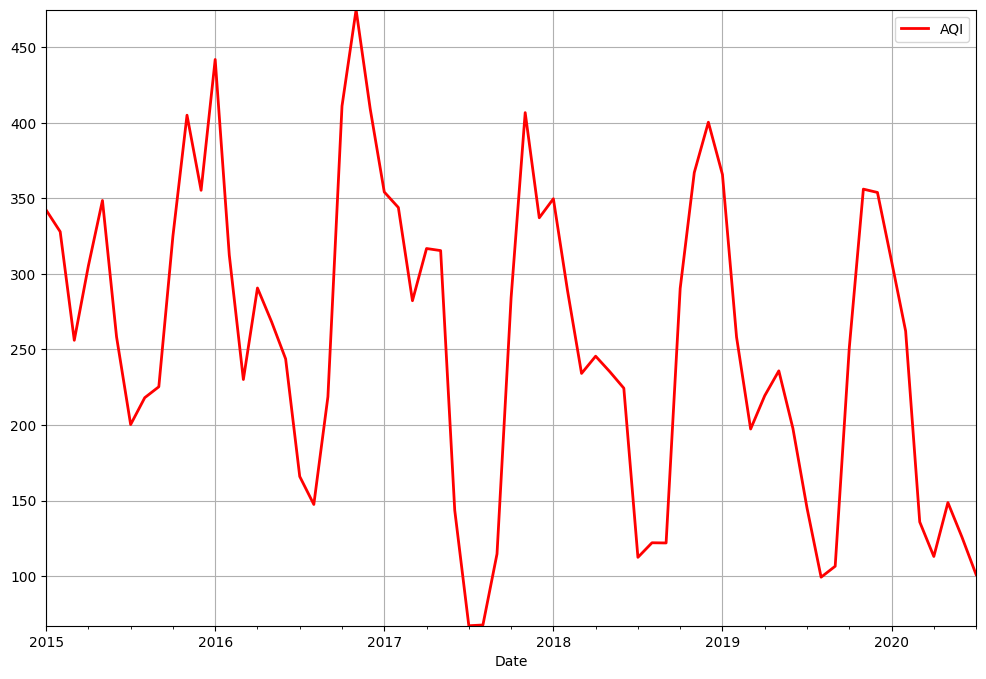

In [56]:
ax=delhi[['AQI']].plot(figsize=(12,8),grid=True,lw=2,color='Red')
ax.autoscale(enable=True, axis='both', tight=True)

## 4. Seasonality diagnostic
Decompose the series (multiplicative) to inspect trend, seasonality, and residual noise before modeling.

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

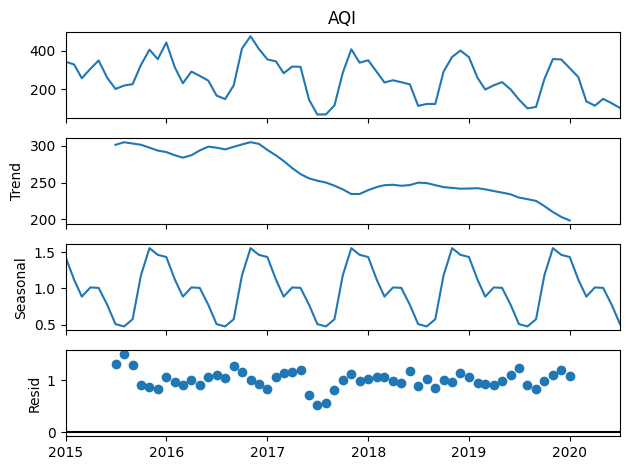

In [58]:
delhi_AQI=delhi['AQI']
result=seasonal_decompose(delhi_AQI,model='multiplicative')
result.plot();

## 5. LSTM forecasting pipeline
We will split into train/test, scale values, create sequences, build a stacked LSTM, train, evaluate, and then forecast 12 months ahead.

In [59]:
#Splitting the training and testing data

train=delhi[:48]
test=delhi[48:61]

In [60]:
type(train)

pandas.core.frame.DataFrame

In [61]:
#print("Shape of train data:" + str(train.array.shape))
#print("Shape of test data:" + str(test.array.shape))

print("Shape of train data:" + str(train.shape))
print("Shape of test data:" + str(test.shape))

Shape of train data:(48, 1)
Shape of test data:(13, 1)


In [62]:
#train_arr=np.expand_dims(train, axis=1)
#test_arr=np.expand_dims(test, axis=1)

train_arr = train
test_arr = test

### 5.1 Scale series
Use `MinMaxScaler` on train/test splits to keep LSTM inputs bounded.

In [63]:
train_arr

,AQI
Date,
2015-01-01,342.290323
2015-02-01,327.928571
2015-03-01,256.064516
2015-04-01,305.266667
2015-05-01,348.580645
2015-06-01,258.333333
2015-07-01,200.290323
2015-08-01,218.064516
2015-09-01,225.300000


In [64]:
#Preprocessing the dataset

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(train_arr)

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [65]:
scaled_train = scaler.transform(train_arr)
scaled_test = scaler.transform(test_arr)

### 5.2 Create supervised sequences
Build sliding-window sequences (`n_input=12` months) for the LSTM.

In [66]:
#Defining our time series generator that would be used to parse data into the model

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [67]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.67487834 0.63964965 0.46337057 0.58406109 0.6903082  0.46893587
 0.32655914 0.37015839 0.38790668 0.63246601 0.82878394 0.70684585]
Predict this y: 
 [[0.91922402]]


### 5.3 Define stacked LSTM
Two 32-unit LSTM layers feed a dense output for next-month AQI.

In [68]:
#Importing the necessary components to define our model

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [69]:
# defining the stacked LSTM model
model = Sequential(name = 'LSTM-Model')
model.add(LSTM(32, activation='relu', return_sequences = True, input_shape=(n_input, n_features),name = "LSTM_1"))
#model.add(LSTM(100, activation='relu', return_sequences = True,name = "LSTM_2"))
#model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu',name = "LSTM_2"))
#model.add(Dropout(0.2))
#model.add(Dense(8))
model.add(Dense(1,name = "DENSE_1"))
model.compile(optimizer= 'adam',  loss='mse')

model.summary()

Model: "LSTM-Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 12, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DENSE_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
#Plotting the layer structure
from keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True,rankdir="TB",dpi=96)


You must install pydot (`pip install pydot`) for `plot_model` to work.


### 5.4 Train the model
Fit on the rolling sequences (50 epochs) and track loss.

In [71]:
#Fitting our model
model.history = model.fit(generator,epochs=50, verbose=0)

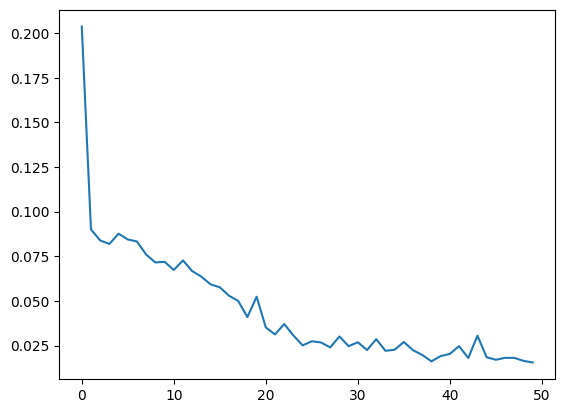

In [72]:
#plotting the loss vs #of epoch 
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

### 6. Evaluate on holdout
Generate rolling forecasts on the test window, compare to actuals, and compute RMSE.

In [73]:
#Predicting using our model on the testing dataset
test_predictions = []

first_batch = scaled_train[-n_input:]
current_batch = first_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
      
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [74]:
test_predictions = scaler.inverse_transform(test_predictions)

In [75]:
print(test_predictions.shape)
print(test_arr.shape)

(13, 1)
(13, 1)


In [76]:
test_arr['Predictions'] = test_predictions

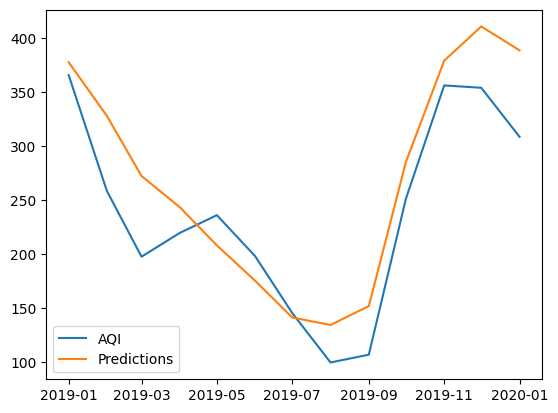

In [77]:
#Plotting the true values vs predicted values on testing dataset
plt.plot(test_arr['AQI'],label = 'AQI')
plt.plot(test_arr['Predictions'],label = 'Predictions')

plt.legend()

In [78]:
#Calculating the root mean squared error on the testing dataset
RMSE_test=np.sqrt(mean_squared_error(test_arr['AQI'],test_arr['Predictions']))
print('RMSE on the testing dataset = ',RMSE_test)
print('India_AQI=',test_arr['AQI'].mean())

RMSE on the testing dataset =  45.60991650902815
India_AQI= 238.0504608294931


In [79]:
#Predicting using our model on the training dataset
train_predictions = []

first_eval_batch = scaled_train[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(train-n_input)):
      
    current_pred = model.predict(current_batch)[0]
    train_predictions.append(current_pred) 
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

In [80]:
train_predictions = scaler.inverse_transform(train_predictions)

In [81]:
print(train_predictions.shape)
print(train_arr.shape)

(48, 1)
(48, 1)


In [82]:
train_arr['Predictions'] = train_predictions

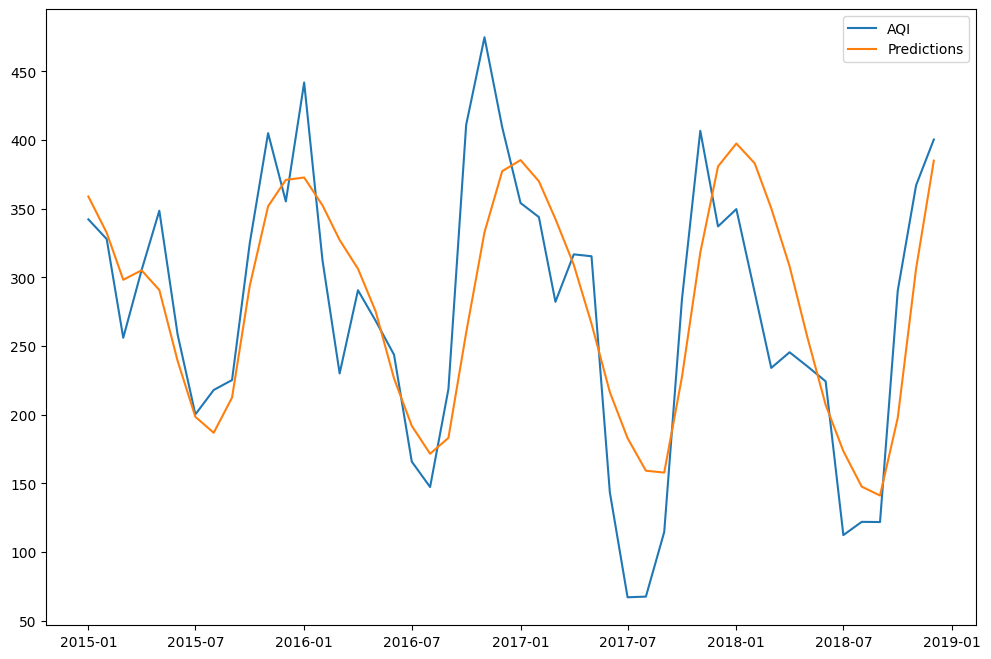

In [83]:
#Plotting the true values vs predicted values on training dataset
plt.figure(figsize=(12,8))
plt.plot(train_arr['AQI'],label = 'AQI')
plt.plot(train_arr['Predictions'],label = 'Predictions')
plt.legend()

In [84]:
#Calculating the root mean squared error on the testing dataset
RMSE_train =np.sqrt(mean_squared_error(train_arr['AQI'],train_arr['Predictions']))
print('RMSE on the training dataset = ',RMSE_train)
print('India_AQI=',train_arr['AQI'].mean())

RMSE on the training dataset =  59.55564408779151
India_AQI= 275.1711046334552


In [85]:
delhi_arr= delhi
scaled_delhi = scaler.transform(delhi_arr)

In [86]:
delhi_arr

,AQI
Date,
2015-01-01,342.290323
2015-02-01,327.928571
2015-03-01,256.064516
2015-04-01,305.266667
2015-05-01,348.580645
...,...
2020-03-01,135.838710
2020-04-01,113.000000
2020-05-01,148.645161


### 7. Forecast the next 12 months
Use the latest 12 months as a seed, roll predictions forward, and plot the projected AQI.

In [87]:
#Making the future predictions using our model
fut_predictions = []

first_eval_batch = scaled_delhi[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(12):
    
    current_pred = model.predict(current_batch)[0]
    
    
    fut_predictions.append(current_pred) 
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [88]:
fut_predictions = scaler.inverse_transform(fut_predictions)

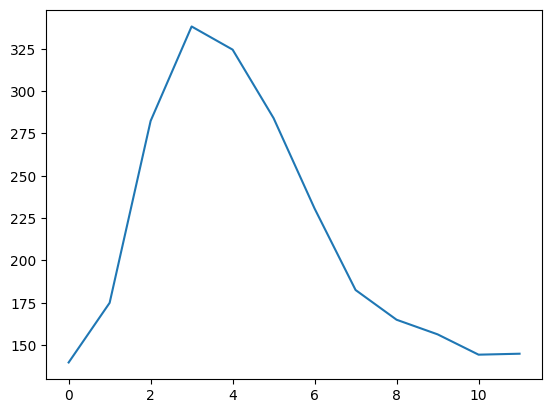

In [89]:
plt.plot(fut_predictions)

In [90]:
complete_pred = np.concatenate((delhi_arr,fut_predictions))

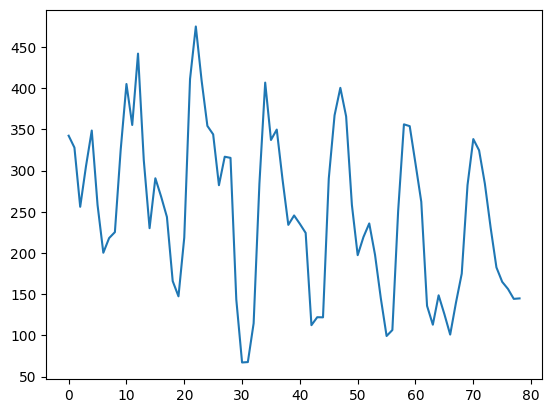

In [91]:
plt.plot(complete_pred)